# How To Use The COSIMA Cookbook

This notebook is designed to help new users get to grips with the COSIMA Cookbook. It assumes that:
 * You have cloned the cosima-cookbook git repository to a location that can see the COSIMA storage space on [NCI](http://cosima-cookbook.readthedocs.io/en/latest/nci.org.au) (/g/data3/hh5/tmp/cosima). We recommend the [Virtual Desktop Infrastructure (VDI)](http://nci.org.au/services/vdi/).
 * You have access to a python3 distribution with the required packages.
 * You have installed the cosima-cookbook package (via `pip install --user -e`).
 * You can fire up a Jupyter notebook!

**Before starting,** load in some libraries that you are likely to need:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs

In addition, you **always** need to load the cosima_cookbook module. This provides a bunch of functions that you will use:

In [2]:
import cosima_cookbook as cc

netcdf_index loaded.


## 1. The Cookbook Philosophy
The COSIMA Cookbook is a framework for analysing ocean-sea ice model output.
It is designed to:
* Provide a library of commonly used diagnostics;
* Write efficient, well-documented, openly accessible code;
* Encourage community input to the code;
* Ensure diagnostic results are reproducible;
* Find methods to deal with the memory limitations of analysing high-resolution model output.


### 1.1 A database of experiments
The database is created and maintained by a function called `build_index`, which stores simulation data in this directory hierachy:
* **configuration** Model resolution (1$^\circ$, 0.25$^\circ$ or 0.1$^\circ$) and submodels (MOM5-SIS1, ACCESS-OM2, etc) 
* **experiment** Individual simulations, usually with multiple output directories
* **netcdf files** Stored inside output directories

The database is shared with other users. You shouldn't need to invoke `build_index` unless you have recently run some new experiments, but if you do need it just use:

In [ ]:
cc.build_index()

### 1.2 Inbuilt Database Functions

We have constructed a few functions to help you operate the cookbook and to access the datasets. These functions all sit in the `cosima_cookbook` directory. For example, `netcdf_index.py` contains the above `build_index` function as well as a series of functions that are built to query the SQL database.

`get_configuration` returns a list of all model configurations that are saved into the database. 

In [3]:
cc.get_configurations()

['mom01v5',
 'APE-MOM',
 'access-om2',
 'mom025',
 'mom-sis',
 'access-om2-025',
 'access-om2-01',
 'woa13',
 'kds75_wp2']

`get_experiments` lists all of the experiments that are catalogued for a given configuration. These function needs one of the above configurations as an input.

In [4]:
cc.get_experiments('access-om2-01')

['01deg_jra55v13_iaf',
 '01deg_jra55v13_ryf8485_freshRCP45',
 '01deg_jra55v13_ryf8485_freshRCP85',
 '01deg_jra55v13_ryf8485_spinup1',
 '01deg_jra55v13_ryf8485_spinup2',
 '01deg_jra55v13_ryf8485_spinup3',
 '01deg_jra55v13_ryf8485_spinup4',
 '01deg_jra55v13_ryf8485_spinup5',
 '01deg_jra55v13_ryf8485_spinup6',
 '01deg_jra55v13_ryf8485_spinup6_dragio_0',
 '01deg_jra55v13_ryf8485_spinup6_dt_720',
 '01deg_jra55v13_ryf8485_spinup6_newtopog',
 '01deg_jra55v13_ryf8485_spinup6_newtopog_scalewind',
 '01deg_jra55v13_ryf8485_spinup6_tripole_bug',
 '01deg_jra55v13_ryf9091_spinup1']

`get_ncfiles` provides a list of all the netcdf filenames saved for a given experiment. Note that each of these filenames are present in some or all of the output directories.

In [5]:
cc.get_ncfiles('01deg_jra55v13_iaf')

['iceh.1986-04-11.nc',
 'iceh.1985-05-05.nc',
 'iceh.1985-02-15.nc',
 'iceh.1987-10-02.nc',
 'iceh.1987-12-12.nc',
 'iceh.1987-11-13.nc',
 'iceh.1987-06-07.nc',
 'iceh.1987-03-13.nc',
 'iceh.1987-08-11.nc',
 'ocean_daily.nc',
 'iceh.1987-08-05.nc',
 'iceh.1987-01-16.nc',
 'iceh.1985-12-05.nc',
 'iceh.1987-10-25.nc',
 'iceh.1987-01-31.nc',
 'iceh.1985-07-17.nc',
 'iceh.1987-04-14.nc',
 'iceh.1987-03-28.nc',
 'rregionindian_ocean_west.nc',
 'ocean_month.nc',
 'o2i.nc',
 'iceh.1985-06-19.nc',
 'iceh.1986-03-29.nc',
 'iceh.1987-03-23.nc',
 'rregionindian_ocean_east.nc',
 'iceh.1986-09-01.nc',
 'iceh.1987-02-25.nc',
 'iceh.1986-06-21.nc',
 'iceh.1986-04-21.nc',
 'iceh.1986-07-20.nc',
 'iceh.1986-12-15.nc',
 'iceh.1987-08-15.nc',
 'iceh.\\d+-\\d+.nc',
 'iceh.1986-12-30.nc',
 'iceh.1985-05-26.nc',
 'iceh.1985-11-15.nc',
 'iceh.1987-07-07.nc',
 'iceh.1987-09-20.nc',
 'ocean_scalar.nc',
 'iceh.1986-03-18.nc',
 'iceh.1987-03-31.nc',
 'iceh.1985-10-29.nc',
 'iceh.1986-07-10.nc',
 'iceh.1985-03-14

We can also read from the database to look for our files

In [8]:
import pandas as pd
import sqlite3
conn = sqlite3.connect(cc.netcdf_index.database_file)

df = pd.read_sql('SELECT id, ncfile, experiment, run, basename, variable '
                 'FROM ncfiles '
                 'WHERE (variable = "u" '
                 ' OR variable = "v") '
                 #'AND basename_pattern LIKE "%!_!_%.nc" ESCAPE "!" '
                 'AND experiment = "01deg_jra55v13_iaf" '
                 'AND configuration = "access-om2-01" '
                 #'GROUP BY configuration, experiment, basename_pattern '
                 #'ORDER BY configuration, experiment, num_files '
                 'ORDER BY ncfile asc'
                 , conn)
df

,id,ncfile,experiment,run,basename,variable
0,42012287,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output001,ocean.nc,u
1,42012288,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output001,ocean.nc,v
2,42034181,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output002,ocean.nc,u
3,42034182,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output002,ocean.nc,v
4,42020416,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output003,ocean.nc,u
5,42020417,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output003,ocean.nc,v
6,42010695,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output004,ocean.nc,u
7,42010696,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output004,ocean.nc,v
8,42002632,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output005,ocean.nc,u
9,42002633,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output005,ocean.nc,v


In [11]:
df = pd.read_sql('SELECT DISTINCT variable, basename '
                 'FROM ncfiles '
                 'WHERE (variable = "u" '
                 ' OR variable = "v") '
                 #'AND basename_pattern LIKE "%!_!_%.nc" ESCAPE "!" '
                 'AND experiment = "01deg_jra55v13_iaf" '
                 'AND configuration = "access-om2-01" '
                 #'GROUP BY configuration, experiment, basename_pattern '
                 #'ORDER BY configuration, experiment, num_files '
                 , conn)
df

,variable,basename
0,u,ocean.nc
1,v,ocean.nc


In [12]:
df = pd.read_sql('SELECT id, ncfile, experiment, run, basename, variable '
                 'FROM ncfiles '
                 'WHERE variable = "salt" '
                 #'AND basename_pattern LIKE "%!_!_%.nc" ESCAPE "!" '
                 'AND experiment = "01deg_jra55v13_iaf" '
                 'AND configuration = "access-om2-01" '
                 #'GROUP BY configuration, experiment, basename_pattern '
                 #'ORDER BY configuration, experiment, num_files '
                 'ORDER BY ncfile asc'
                 , conn)
df

,id,ncfile,experiment,run,basename,variable
0,42012285,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output001,ocean.nc,salt
1,42034179,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output002,ocean.nc,salt
2,42020414,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output003,ocean.nc,salt
3,42010693,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output004,ocean.nc,salt
4,42002630,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output005,ocean.nc,salt
5,42049380,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output006,ocean.nc,salt
6,42052481,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output007,ocean.nc,salt
7,42005243,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output008,ocean.nc,salt
8,42015331,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output009,ocean.nc,salt
9,42019807,/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jr...,01deg_jra55v13_iaf,output010,ocean.nc,salt


In [13]:
df = pd.read_sql('SELECT DISTINCT variable, basename '
                 'FROM ncfiles '
                 'WHERE variable = "salt" '
                 #'AND basename_pattern LIKE "%!_!_%.nc" ESCAPE "!" '
                 'AND experiment = "01deg_jra55v13_iaf" '
                 'AND configuration = "access-om2-01" '
                 #'GROUP BY configuration, experiment, basename_pattern '
                 #'ORDER BY configuration, experiment, num_files '
                 , conn)
df

,variable,basename
0,salt,ocean.nc


And finally, `get_variables` provides a list of all the variables available in a specific netcdf file. This functions requires both the experiment and the filename to be provided.

In [14]:
cc.get_variables('01deg_jra55v13_iaf','ocean.nc')

['xt_ocean',
 'yt_ocean',
 'st_ocean',
 'st_edges_ocean',
 'time',
 'nv',
 'xu_ocean',
 'yu_ocean',
 'sw_ocean',
 'sw_edges_ocean',
 'grid_xu_ocean',
 'grid_yt_ocean',
 'potrho',
 'potrho_edges',
 'grid_xt_ocean',
 'grid_yu_ocean',
 'neutral',
 'neutralrho_edges',
 'temp',
 'salt',
 'age_global',
 'u',
 'v',
 'wt',
 'dzt',
 'press',
 'rho',
 'pot_rho_0',
 'pot_rho_2',
 'tx_trans',
 'ty_trans',
 'ty_trans_submeso',
 'tx_trans_rho',
 'ty_trans_rho',
 'ty_trans_nrho_submeso',
 'temp_xflux_adv',
 'temp_yflux_adv',
 'diff_cbt_t',
 'buoyfreq2_wt',
 'speed',
 'vert_pv',
 'average_T1',
 'average_T2',
 'average_DT',
 'time_bounds',
 'aiso_bih']

### 1.3 Loading data from a netcdf file

Python has many ways of reading in data from a netcdf file ... so we thought we would add another way. This is achieved in the `get_nc_variable` function, which is the most commonly used function in the cookbook. This function queries the database to find a variable from a specific file, from a specific variable, and loads some or all of that file. We will now take a little while to get to know this function. In it's simplest form, you need just three arguments: expt, ncfile and variable. 

You can see all the available options using the inbuilt help function, which brings up the function documentation.

In [15]:
help(cc.get_nc_variable)

Help on function get_nc_variable in module cosima_cookbook.netcdf_index:

get_nc_variable(expt, ncfile, variable, chunks={}, n=None, op=None, time_units='days since 1900-01-01', use_bag=False)
    For a given experiment, concatenate together
    variable over all time given a basename ncfile.
    
    Since some NetCDF4 files have trailing integers (e.g. ocean_123_456.nc)
    ncfile can use glob syntax http://www.sqlitetutorial.net/sqlite-glob/
    and regular expressions also work in some limited cases.
    
    By default, xarray is set to use the same chunking pattern that is
    stored in the ncfile. This can be overwritten by passing in a dictionary
    chunks or setting chunks=None for no chunking (load directly into memory).
    
    n < 0 means only use the last |n| ncfiles files.
    n > 0 means only use the first n ncfiles files.
    
    op() is function to apply to each variable before concatenating.
    
    time_units (e.g. "days since 1600-01-01") can be used to override

You may like to note a few things about this function:
1. The data is returned as an xarray DataArray, which includes the coordinate and attribute information from the netcdf file (more on xarray later). 
2. The variable time does not start at zero (like the netcdf file) - we generally shift it to be in a data range that allows us to use `pandas` time series and date functionality.
3. By default, we load the whole dataset, but we could just load the last `n` netcdf files (useful for testing).
4. Other customisable options include setting the variable chunking and incorporating a function to operate on the data.

In [58]:
cc.get_nc_variable('01deg_jra55v13_iaf',\
                   'ocean.nc','u')

<xarray.DataArray 'u' (time: 396, st_ocean: 75, yu_ocean: 2700, xu_ocean: 3600)>
dask.array<shape=(396, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400)>
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * time      (time) datetime64[ns] 1985-01-14T12:00:00 ... 2017-12-14T12:00:00
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  sea_water_x_velocity

In [18]:
cc.get_nc_variable('01deg_jra55v13_iaf',\
                   'ocean.nc','salt',chunks={'time':10})

<xarray.DataArray 'salt' (time: 396, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<shape=(396, 75, 2700, 3600), dtype=float32, chunksize=(3, 7, 300, 400)>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) datetime64[ns] 1985-01-14T12:00:00 ... 2017-12-14T12:00:00
Attributes:
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_salinity

### 1.4 Exercises
OK, this is a tutorial, so now you have to do some work. Your tasks are to:
* Find and load Salt from an experiment

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


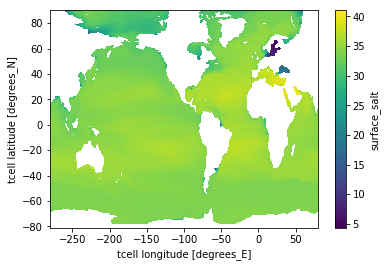

In [24]:
salt = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean_month.nc','surface_salt',n=1)
salt.mean('time').plot()

* Load potential temperature from an experiment (again, 1° would be quickest). Can you chunk the data differently from the default?

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


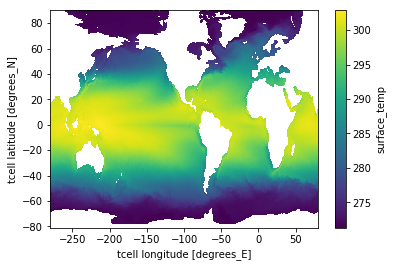

In [25]:
temp = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean_month.nc','surface_temp',n=1)
temp.mean('time').plot()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


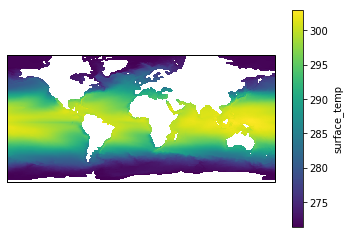

In [62]:
#temp = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean_month.nc','surface_temp',n=1)
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())
temp.mean('time').plot(ax=ax, transform=ccrs.PlateCarree())

#temp.mean('time').plot()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0, 'longitude')

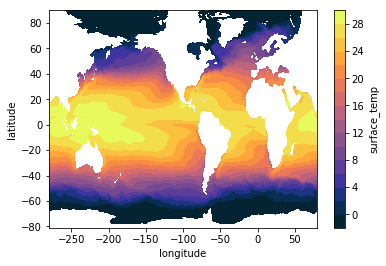

In [27]:
darray = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean_month.nc','surface_temp',n=1)
darray = darray - 273.15 # convert from Kelvin to Celsius
darray.mean('time').plot.contourf(levels=np.arange(-2,32,2),cmap=cm.cm.thermal)
plt.ylabel('latitude')
plt.xlabel('longitude')

## Let's look at Parcels now using COSIMA

In [49]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ScipyParticle
from datetime import timedelta, datetime

import parcels
parcels.
print('Parcels Version:',parcels.version)

Parcels Version: 2.0.0b1.dev32+gcb16888


In [30]:
uarray = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean.nc','u',n=-5)
uarray

<xarray.DataArray 'u' (time: 10, st_ocean: 50, yu_ocean: 1080, xu_ocean: 1440)>
dask.array<shape=(10, 50, 1080, 1440), dtype=float32, chunksize=(1, 10, 216, 288)>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * time      (time) datetime64[ns] 2084-05-17T12:00:00 ... 2093-05-15T12:00:00
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  sea_water_x_velocity

In [31]:
varray = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean.nc','v',n=-5)
varray

<xarray.DataArray 'v' (time: 10, st_ocean: 50, yu_ocean: 1080, xu_ocean: 1440)>
dask.array<shape=(10, 50, 1080, 1440), dtype=float32, chunksize=(1, 10, 216, 288)>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * time      (time) datetime64[ns] 2084-05-17T12:00:00 ... 2093-05-15T12:00:00
Attributes:
    long_name:      j-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  sea_water_y_velocity

Let's make a merged xarray dataset to use

In [39]:
velarray = xr.merge([uarray, varray])
velarray

<xarray.Dataset>
Dimensions:   (st_ocean: 50, time: 10, xu_ocean: 1440, yu_ocean: 1080)
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * xu_ocean  (xu_ocean) float64 -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * time      (time) datetime64[ns] 2084-05-17T12:00:00 ... 2093-05-15T12:00:00
Data variables:
    u         (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<shape=(10, 50, 1080, 1440), chunksize=(1, 10, 216, 288)>
    v         (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<shape=(10, 50, 1080, 1440), chunksize=(1, 10, 216, 288)>

In [41]:
modelname = 'access-OM2'
experimentname = '025deg_jra55v13_ryf8485_spinup_A'


variables = {'U': 'u',
             'V': 'v'}

dimensions = {'lat': 'yu_ocean',
              'lon': 'xu_ocean',
              'time': 'time',
              'depth': 'st_ocean'}


fieldset = FieldSet.from_xarray_dataset(velarray, variables, dimensions)

print("Longitude Range:", np.min(fieldset.U.lon),"to",np.max(fieldset.U.lon))
print("Latitude Range:", np.min(fieldset.U.lat),"to",np.max(fieldset.U.lat))

Longitude Range: -279.75 to 80.0
Latitude Range: -81.0242 to 90.0


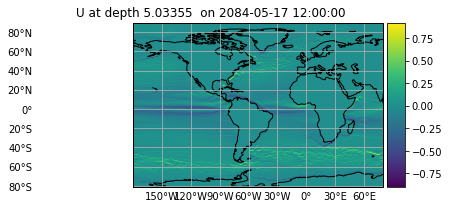

In [42]:
fieldset.U.show()

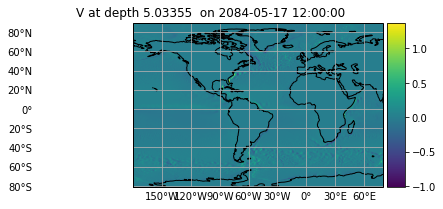

In [43]:
fieldset.V.show()

Now let's create a set of particles to advect.

In [44]:
start_lon = -20 #-145
end_lon = 10 #-165
n_lon = np.abs(start_lon - end_lon)

start_lat = -20. #
end_lat = -40.
n_lat = np.abs(start_lat - end_lat)

[longitude, latitude] = np.meshgrid(np.linspace(start_lon, end_lon,n_lon), np.linspace(start_lat, end_lat,n_lat), indexing='ij')


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


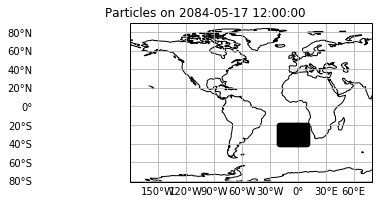

In [45]:
#create particle set and show
pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle, lon=longitude, lat=latitude)
pset.show()


In [50]:
output_file = pset.ParticleFile(name='parcels_example_trajectories.nc', outputdt=timedelta(days=1))
pset.execute(AdvectionRK4, runtime=timedelta(days=5), dt=timedelta(hours=1), output_file=output_file)

INFO: Compiled JITParticleAdvectionRK4 ==> /local/v45/md6918/tmp/parcels-13402/42f73df080ab5cf75b02ac46770b4a0a.so
INFO:parcels.tools.loggers:Compiled JITParticleAdvectionRK4 ==> /local/v45/md6918/tmp/parcels-13402/42f73df080ab5cf75b02ac46770b4a0a.so


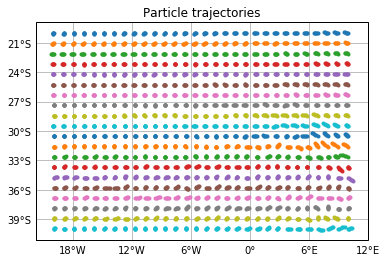

<module 'matplotlib.pyplot' from '/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [51]:
plotTrajectoriesFile('parcels_example_trajectories2.nc')

In [53]:
output_file = pset.ParticleFile(name='parcels_example_trajectories2.nc', outputdt=timedelta(days=1))
pset.execute(AdvectionRK4, runtime=timedelta(days=50), dt=timedelta(hours=1), output_file=output_file)

100% (4320000.0 of 4320000.0) |##########| Elapsed Time: 0:00:40 Time:  0:00:40


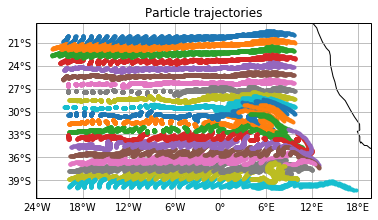

<module 'matplotlib.pyplot' from '/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [54]:
plotTrajectoriesFile('parcels_example_trajectories2.nc')

In [55]:
output_file = pset.ParticleFile(name='parcels_example_trajectories3.nc', outputdt=timedelta(days=1))
pset.execute(AdvectionRK4, runtime=timedelta(days=365), dt=timedelta(hours=1), output_file=output_file)

100% (31536000.0 of 31536000.0) |########| Elapsed Time: 0:06:22 Time:  0:06:22


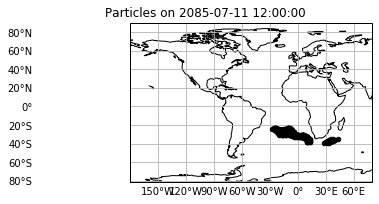

In [56]:
pset.show()

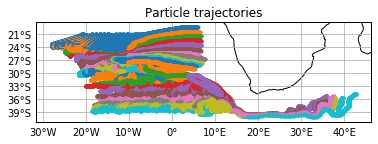

<module 'matplotlib.pyplot' from '/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [57]:
plotTrajectoriesFile('parcels_example_trajectories3.nc')